In [2]:
import numpy as np
import torch
import torch.nn as nn      
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cv2
from PIL import Image
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5
import tqdm
from numpy import moveaxis
import scipy.ndimage
from IPython.display import clear_output
import time


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 7, 5)
        self.pool = nn.MaxPool2d(3, 3)
        
        self.dropout = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(7, 10, 5)
        
        
        self.fc1 = nn.Linear(90, 60)
        self.fc2 = nn.Linear(60, 30)
        self.fc3 = nn.Linear(30, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
hunter = Net()
hunter.load_state_dict(torch.load("hunter.pt"))
hunter.eval()

Net(
  (conv1): Conv2d(3, 7, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(7, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=90, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=4, bias=True)
)

In [4]:
def generate_heatmap(input_tensor, model, kernel_size, stride, thresh_prob, label):
    image = input_tensor
    
    width, height = image.shape[-2], image.shape[-1]
    #setting the output image width and height
    output_height = int(np.ceil((height-kernel_size)/stride))
    output_width = int(np.ceil((width-kernel_size)/stride))
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_width, output_height))
    for h in range(0, height):
        for w in range(0, width):
            h_start = h*stride
            w_start = w*stride
            h_end = min(height, h_start + kernel_size)
            w_end = min(width, w_start + kernel_size)
            if (w_end) >= width or (h_end) >= height:
                continue
            input_image = image.clone().detach()
            
            tensor_slice = input_image[:, :, w_start:w_end, h_start:h_end].squeeze(0)
            
            if 0 in tensor_slice.size():
                continue
            
            sweet_slice = np.moveaxis(tensor_slice.numpy(), 0, 2)

            sweet_slice = cv2.resize(sweet_slice, (50,50))

            sweet_tensor =  torch.from_numpy(np.moveaxis(sweet_slice, 2,0)).unsqueeze(0)
            output = model(sweet_tensor).flatten()
            
            output = torch.softmax(output, dim = 0)[label].item()
            
            if  output > thresh_prob:
                heatmap[w,h] = output*200  # mult
                
                
#                 plt.imshow(sweet_slice.astype("uint8"))
#                 plt.show()
                
            else:
                heatmap[w,h] =  0.5 
                
    return heatmap.detach().numpy()

def detect_animal_heatmap(model, image_path, kernel_size, stride, label, threshold_prob):
    
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im2 = cv2.resize(im, (int(im.shape[1]/3), int(im.shape[0]/3)))
    plt.imshow(im2)
    plt.show()
   
    im2 = moveaxis(im2, 2, 0)

    input_tensor = torch.from_numpy(im2).unsqueeze(0).float()  ## tensor ready to be fed to nn 
    heatmap = generate_heatmap(input_tensor, model, kernel_size, stride, threshold_prob, label)
    print(heatmap.shape)

    heat_shape = im.shape[:-1][::-1]
    heatmap = cv2.resize(heatmap,heat_shape )
    
    
    heatmap = scipy.ndimage.filters.gaussian_filter(heatmap, sigma = [16,16]) ## smoothen 2d image
    plt.set_cmap("jet_r")

    plt.imshow(heatmap)
    plt.show()

    plt.imsave("heatmap.png", heatmap)
    fin = cv2.addWeighted(cv2.imread(image_path), 0.6,cv2.imread("heatmap.png"),0.5, 0)
#     heatmap = cv2.Canny(cv2.imread("heatmap.png",  cv2.IMREAD_GRAYSCALE),100,10)
    f , axarr = plt.subplots(1,3)
    axarr[0].imshow(im, cmap = "gray")
    axarr[1].imshow(heatmap)
#     axarr[1].colorbar()
    axarr[2].imshow(fin)

    return fin

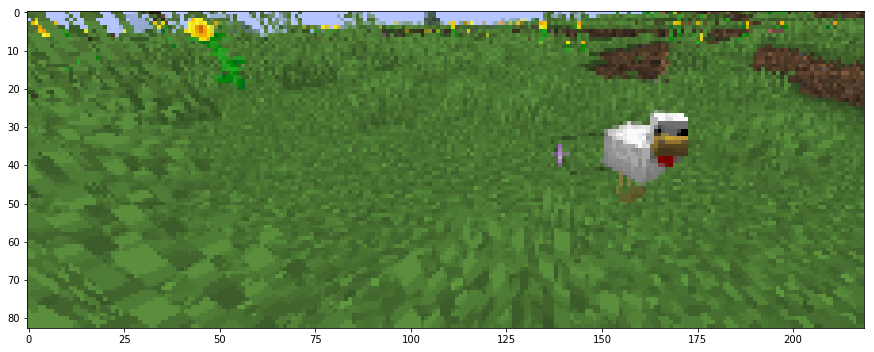

(11, 38)


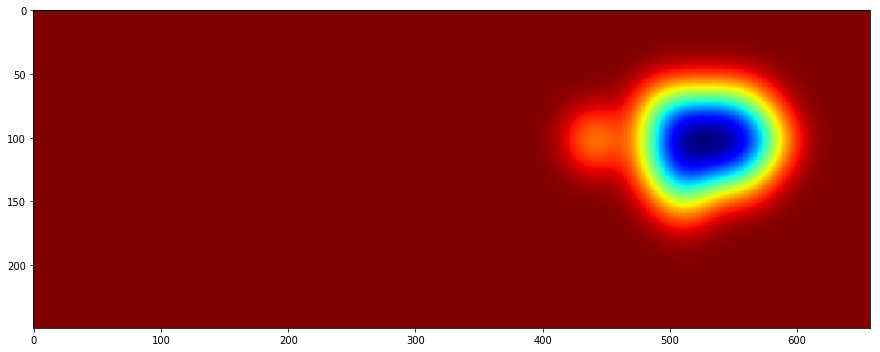

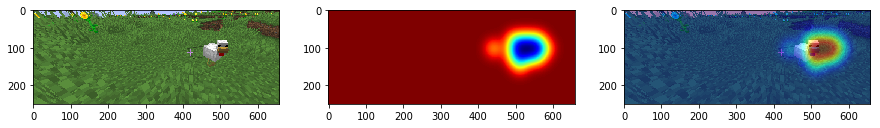

In [5]:
rcParams['figure.figsize'] = 15, 8
foo = detect_animal_heatmap(hunter, "barbecue_boi.png", 30, 5, 0, 0.99)

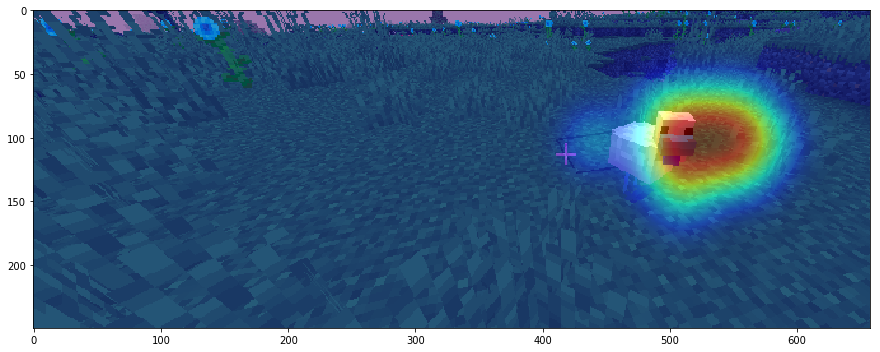

In [6]:
plt.imshow(foo)

In [6]:


from mss.linux import MSS as mss
import mss.tools

def screen_cap(top = 0, left = 0, width = 650, height = 480):
    mon = {"top": top, "left": left, "width": width, "height": height}
    sct = mss.mss()
    img = np.array(sct.grab(mon))[...,:3]
    sct.close()
    return img
 

## single circle 

In [5]:
def return_target_numpy(input_np_arr, model, kernel_size, stride, thresh_prob, label):
    image = input_np_arr
    width, height = image.shape[1], image.shape[0]
    circles = []
    image_ret = image.copy()
    for h in range(0, height):
        for w in range(0, width):
            h_start = h*stride
            w_start = w*stride
            h_end = min(height, h_start + kernel_size)
            w_end = min(width, w_start + kernel_size)
            if (w_end) >= width or (h_end) >= height:
                continue
            
            np_slice = image[h_start:h_end, w_start:w_end, :]

            if 0 in np_slice.shape:
                continue
            np_slice = cv2.resize(np_slice, (50,50))   
            image_moveaxis =  np.moveaxis(np_slice, 2, 0)    
        
            sweet_tensor =  torch.from_numpy(image_moveaxis).unsqueeze(0).float()
            output = model(sweet_tensor).flatten()
            output = torch.softmax(output, dim = 0)[label].item()
            
            if  output > thresh_prob:
                
                circle_center = [int((w_end+w_start)/2), int((h_end+h_start)/2)]
                circles.append(circle_center)
            else:
                pass 
    print(circles)
    
    if len(circles) != 0:
        
        target = np.mean(np.array(circles), axis = 0).astype(np.uint8)
        print(target)

        cv2.circle(image_ret, tuple(target), radius = int(kernel_size/4), color = (0, 255, 255) , thickness = 1)


    return image_ret

In [7]:
def generate_circles_numpy(input_np_arr, model, kernel_size, stride, thresh_prob, label):
    image = input_np_arr
    width, height = image.shape[1], image.shape[0]
 
    image_ret = image.copy()
    for h in range(0, height):
        for w in range(0, width):
            h_start = h*stride
            w_start = w*stride
            h_end = min(height, h_start + kernel_size)
            w_end = min(width, w_start + kernel_size)
            if (w_end) >= width or (h_end) >= height:
                continue
            
            np_slice = image[h_start:h_end, w_start:w_end, :]

            if 0 in np_slice.shape:
                continue
            np_slice = cv2.resize(np_slice, (50,50))   
            image_moveaxis =  np.moveaxis(np_slice, 2, 0)    
        
            sweet_tensor =  torch.from_numpy(image_moveaxis).unsqueeze(0).float()
            output = model(sweet_tensor).flatten()
            output = torch.softmax(output, dim = 0)[label].item()
            
            if  output > thresh_prob:
                
                circle_center = (int((w_end+w_start)/2), int((h_end+h_start)/2))
                cv2.circle(image_ret, circle_center, radius = int(kernel_size/4), color = (0, 255, 255) , thickness = 1)
            else:
                pass 

    return image_ret

In [9]:

print ("press q to quit")
while True:
    start = time.time()
    frame = screen_cap(top= 140, height = 410)
    frame2 = cv2.resize(frame, (int(frame.shape[1]/4), int(frame.shape[0]/4)))
    clear_output(wait = True)
    frame2 = return_target_numpy(frame2,hunter, 40, 15, 0.9, 0)
    
    
    frame2 = cv2.resize(frame2, frame.shape[:-1][::-1])
    cv2.imshow("hunter_fpv",frame2)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows() 
        break
    time_taken = time.time() - start
    
    print(int(1/time_taken), " FPS")


[]
